In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd gdrive/My Drive/AE4317OF/simulation/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/AE4317OF/simulation


In [2]:
def filter_color(image, y_low = 50, y_high = 200, \
                 u_low = 120, u_high = 130, v_low = 120, v_high = 130, resize_factor=1):
    #im = cv2.imread(image_name);
    im = image;
    im = cv2.resize(im, (int(im.shape[1]/resize_factor), int(im.shape[0]/resize_factor)));
    YUV = cv2.cvtColor(im, cv2.COLOR_BGR2YUV);
    Filtered = np.zeros([YUV.shape[0], YUV.shape[1]], np.uint8);
    for y in range(YUV.shape[0]):
        for x in range(YUV.shape[1]):
            if(YUV[y,x,0] >= y_low and YUV[y,x,0] <= y_high and \
               YUV[y,x,1] >= u_low and YUV[y,x,1] <= u_high and \
               YUV[y,x,2] >= v_low and YUV[y,x,2] <= v_high):
                Filtered[y,x] = 1;
    #plt.figure()
    #plt.imshow(Filtered);
    #plt.title('Filtered image');
    return Filtered;

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


error: ignored

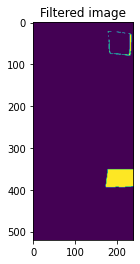

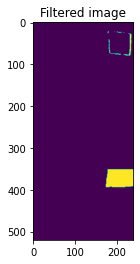

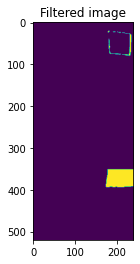

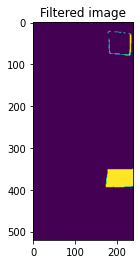

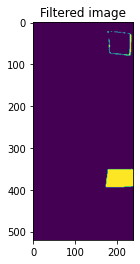

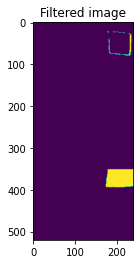

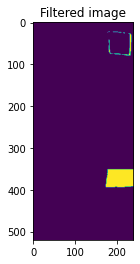

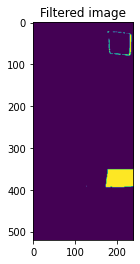

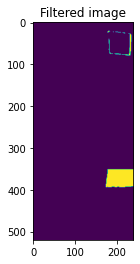

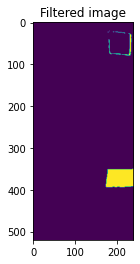

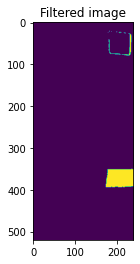

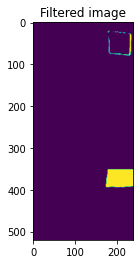

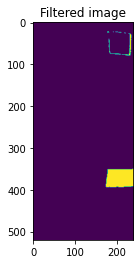

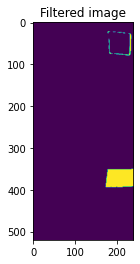

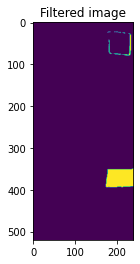

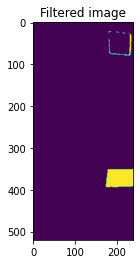

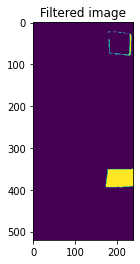

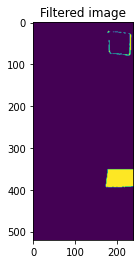

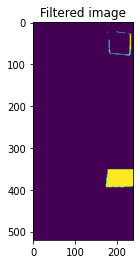

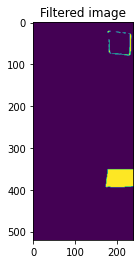

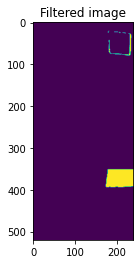

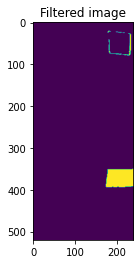

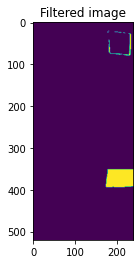

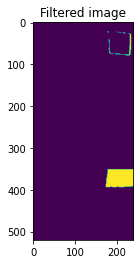

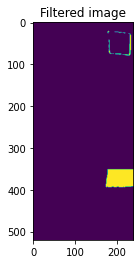

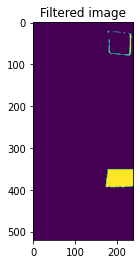

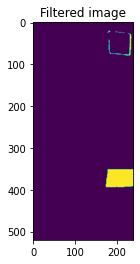

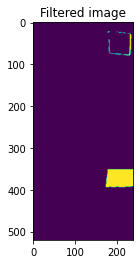

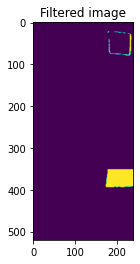

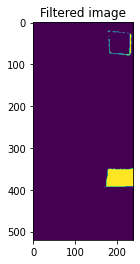

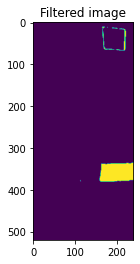

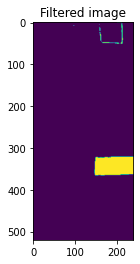

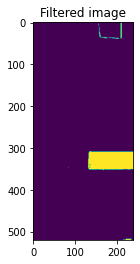

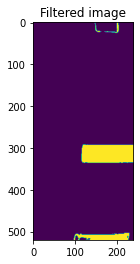

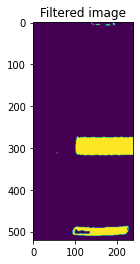

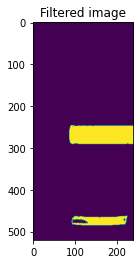

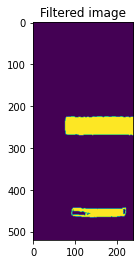

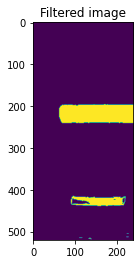

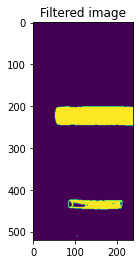

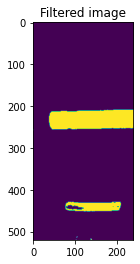

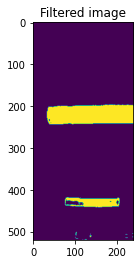

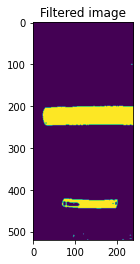

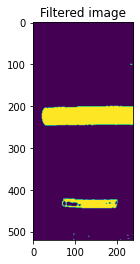

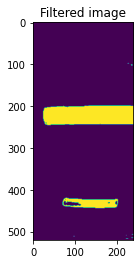

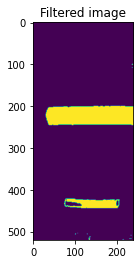

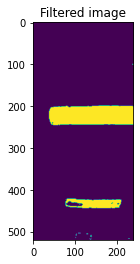

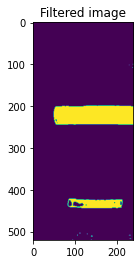

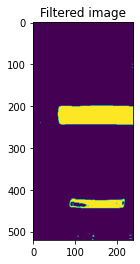

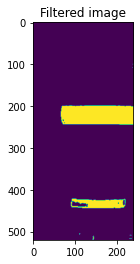

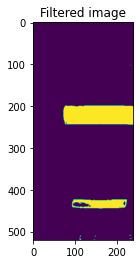

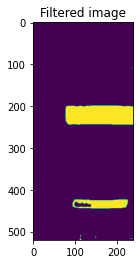

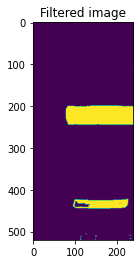

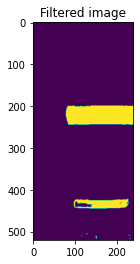

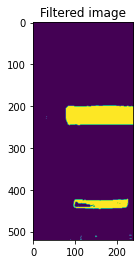

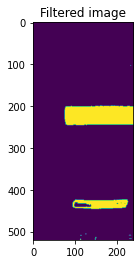

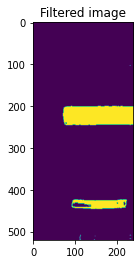

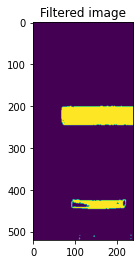

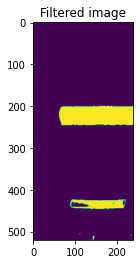

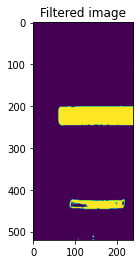

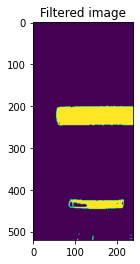

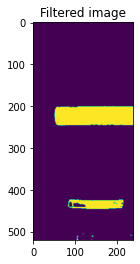

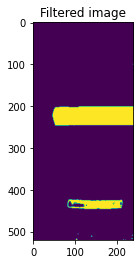

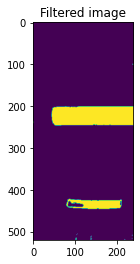

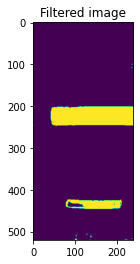

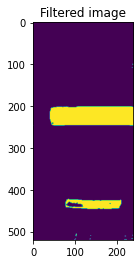

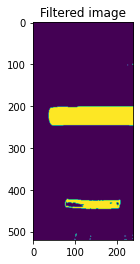

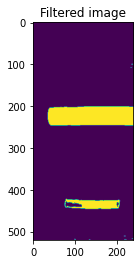

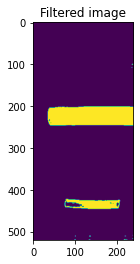

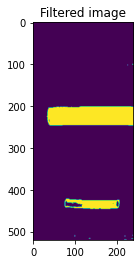

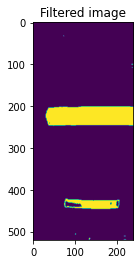

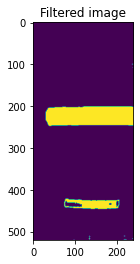

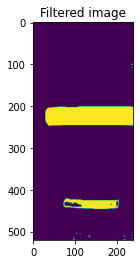

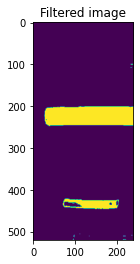

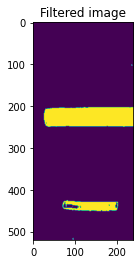

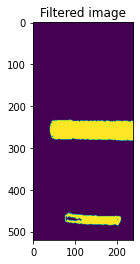

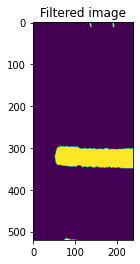

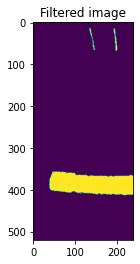

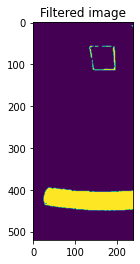

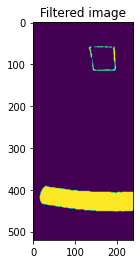

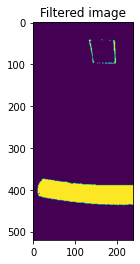

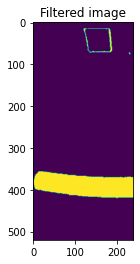

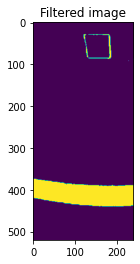

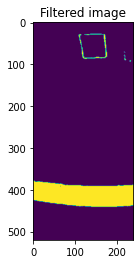

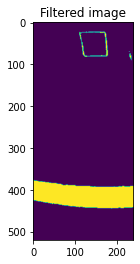

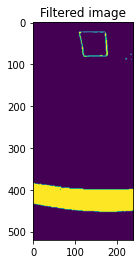

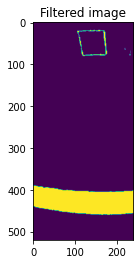

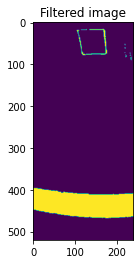

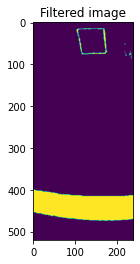

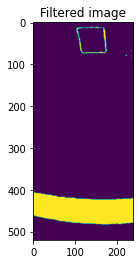

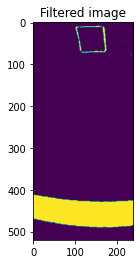

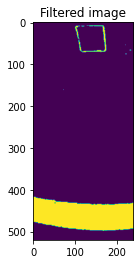

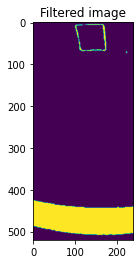

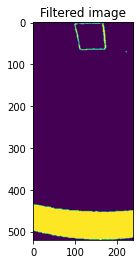

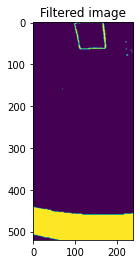

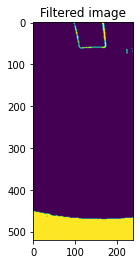

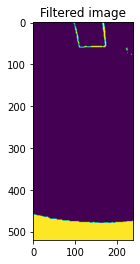

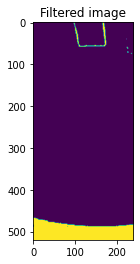

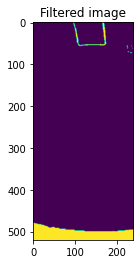

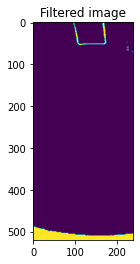

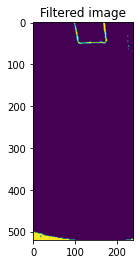

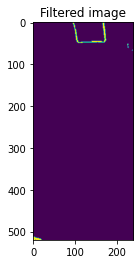

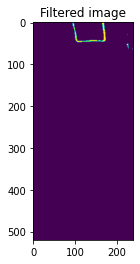

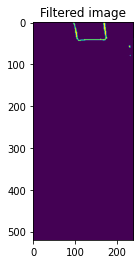

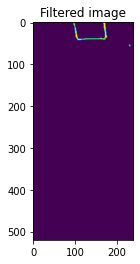

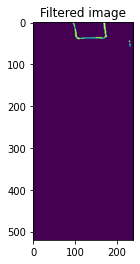

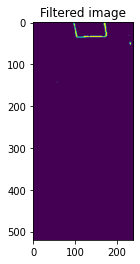

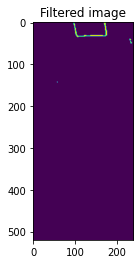

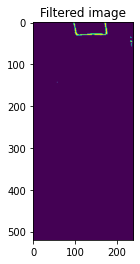

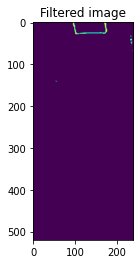

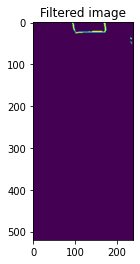

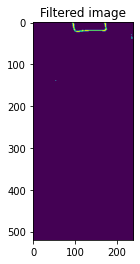

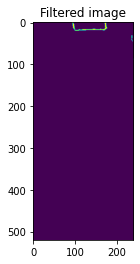

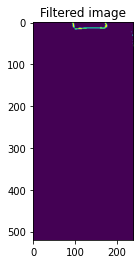

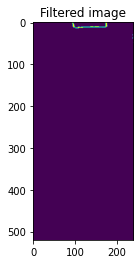

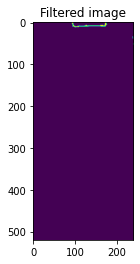

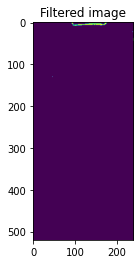

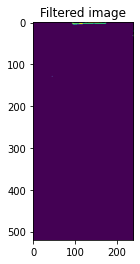

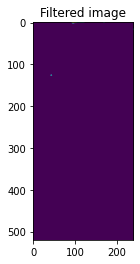

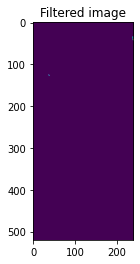

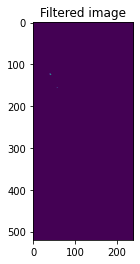

In [5]:
#OF.extract_flow_information(flow_graphics=False, verbose=False);
%matplotlib inline
import extract_information_flow_field as OF

import numpy as np
import matplotlib.pyplot as plt
import os
import re
import time
import sys
import cv2

# parameters - keep them like this:
image_dir_name = './AE4317_2019_datasets/cyberzoo_poles/imgs/';
image_type = 'jpg'; 
verbose=False;
graphics =True;
flow_graphics = False;
    
# get the image names from the directory:
image_names = [];
for file in os.listdir(image_dir_name):
    if file.endswith(image_type):
        image_names.append(image_dir_name + file);
if sys.version_info[0] < 3:
    # Python 2:
    image_names.sort(cmp=compare_file_names);
else:
    # Python 3:
    image_names.sort(key=OF.get_number_file_name);

# iterate over the images:
n_images = len(image_names);
FoE_over_time = np.zeros([n_images, 2]);
horizontal_motion_over_time = np.zeros([n_images, 1]);
vertical_motion_over_time = np.zeros([n_images, 1]);
divergence_over_time = np.zeros([n_images, 1]);
errors_over_time = np.zeros([n_images, 1]);
elapsed_times = np.zeros([n_images,1]);
ttc_over_time = np.zeros([n_images,1]);
FoE = np.asarray([0.0]*2);
time_to_contact = 0.0;
for im in np.arange(0, n_images, 1):

    bgr = cv2.imread(image_names[im]);
    #plt.figure()
    #plt.imshow(bgr);
    #plt.title('Original image');
    #print(image_names[im])
    #test_gray = cv2.cvtColor(bgr, cv2.COLOR_RGB2GRAY);
    #print(test_gray)
    gray = filter_color(image=bgr, u_low=0, u_high=120, v_low=160, v_high=220)

    if(im > 0):

        t_before = time.time()
        # determine optical flow:
        points_old, points_new, flow_vectors = OF.determine_optical_flow(prev_gray, gray, graphics=flow_graphics);
        # do stuff
        elapsed = time.time() - t_before;
        if(verbose):
            print('Elapsed time = {}'.format(elapsed));
        elapsed_times[im] = elapsed;

        # convert the pixels to a frame where the coordinate in the center is (0,0)
        points_old -= 128.0;

        # extract the parameters of the flow field:
        pu, pv, err = OF.estimate_linear_flow_field(points_old, flow_vectors, RANSAC=True);
        
        # ***********************************
        # EXERCISE:
        # change the following lines of code!
        # ***********************************
        horizontal_motion = -pu[2];
        vertical_motion = -pv[2];
        divergence = (pu[0] + pv[1]) / 2.0;
        small_threshold = 1E-5;
        if(abs(pu[0]) > small_threshold):
            FoE[0] = pu[2] / pu[0]; 
        if(abs(pv[1]) > small_threshold):
            FoE[1] = pv[2] / pv[1];    
        if(abs(divergence) > small_threshold):
            time_to_contact = 1 / divergence;

        # book keeping:
        horizontal_motion_over_time[im] = horizontal_motion;
        vertical_motion_over_time[im] = vertical_motion;
        FoE_over_time[im, 0] = FoE[0];
        FoE_over_time[im, 1] = FoE[1];
        divergence_over_time[im] = divergence;
        errors_over_time[im] = err;
        ttc_over_time[im] = time_to_contact;

        if(verbose):
            # print the FoE and divergence:
            print('error = {}, FoE = {}, {}, and divergence = {}'.format(err, FoE[0], FoE[1], divergence));

    # the current image becomes the previous image:
    prev_gray = gray;
    
if(verbose):
    print('*** average elapsed time = {} ***'.format(np.mean(elapsed_times[1:,0])));

if(graphics):

    # ********************************************************************
    # TODO:
    # What is the unit of the divergence?
    # Can you also draw the time-to-contact over time? In what unit is it?
    # ********************************************************************

    plt.figure();
    plt.plot(range(n_images), divergence_over_time, label='Divergence');
    plt.xlabel('Image')
    plt.ylabel('Divergence')

    plt.figure();
    plt.plot(range(n_images), FoE_over_time[:,0], label='FoE[0]');
    plt.plot(range(n_images), FoE_over_time[:,1], label='FoE[1]');
    plt.plot(range(n_images), np.asarray([0.0]*n_images), label='Center of the image')
    plt.legend();
    plt.xlabel('Image')
    plt.ylabel('FoE')

    plt.figure();
    plt.plot(range(n_images), errors_over_time, label='Error');
    plt.xlabel('Image')
    plt.ylabel('Error')

    plt.figure();
    plt.plot(range(n_images), horizontal_motion_over_time, label='Horizontal motion');
    plt.plot(range(n_images), vertical_motion_over_time, label='Vertical motion');
    plt.legend();
    plt.xlabel('Image')
    plt.ylabel('Motion U/Z, V/Z')       

    plt.figure();
    plt.plot(range(n_images), ttc_over_time, label='Time-to-contact');
    plt.xlabel('Image')
    plt.ylabel('Time-to-contact')